In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Fetch historical data
ticker = "AAPL"
historical_data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
historical_data['SMA_20'] = historical_data['Close'].rolling(window=20).mean()
historical_data['Volatility'] = historical_data['Close'].pct_change().rolling(window=20).std()
historical_data['RSI'] = (100 - (100 / (1 + (historical_data['Close'].pct_change().clip(lower=0).rolling(14).mean()) /
                                       (historical_data['Close'].pct_change().clip(upper=0).abs().rolling(14).mean()))))

# Drop NaN values
historical_data = historical_data.dropna()

# Define features (independent variables) and target (dependent variable)
X = historical_data[['SMA_20', 'Volatility', 'RSI']]
"""
Predicting the Next Day's Close: By shifting the target data, each row of X 
(today’s features) is matched with the following day’s closing price in y. 
This setup helps train the model to learn the relationship between today’s 
indicators and tomorrow’s closing price.
"""
y = historical_data['Close'].shift(-1).dropna()  # Predict the next day's close

# Align X and y after shifting
# excludes last row
X = X.iloc[:-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[*********************100%***********************]  1 of 1 completed


In [2]:
# Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 14.611163978407875


In [4]:
# After training the linear regression model
print("Linear Regression Coefficients:")
for feature, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature}: {coef}")


Linear Regression Coefficients:
('SMA_20', ''): [ 8.84048868e-01 -3.59808680e+02  2.58034317e-01]


In [8]:
# Ridge regression
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print("Ridge Regression MSE:", ridge_mse)

# Lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print("Lasso Regression MSE:", lasso_mse)


Ridge Regression MSE: 11.859917147923058
Lasso Regression MSE: 11.878955494822307


In [9]:
from sklearn.linear_model import RidgeCV, LassoCV

# helps us choose alpha values

# Define a range of alpha values
alpha_range = [0.001, 0.01, 0.1, 1, 10, 100]

# For Ridge Regression with Cross-Validation
ridge_cv_model = RidgeCV(alphas=alpha_range, cv=5)  # 5-fold cross-validation
ridge_cv_model.fit(X_train, y_train)
best_alpha_ridge = ridge_cv_model.alpha_
print("Best Alpha for Ridge Regression:", best_alpha_ridge)

# For Lasso Regression with Cross-Validation
lasso_cv_model = LassoCV(alphas=alpha_range, cv=5)
lasso_cv_model.fit(X_train, y_train)
best_alpha_lasso = lasso_cv_model.alpha_
print("Best Alpha for Lasso Regression:", best_alpha_lasso)


Best Alpha for Ridge Regression: 0.001
Best Alpha for Lasso Regression: 0.001


/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define target as 1 if price goes up the next day, 0 if it goes down
# target indicates if price will go up or down the next day
# compares next days closing price with current days closing price
historical_data['Target'] = (historical_data['Close'].shift(-1) > historical_data['Close']).astype(int)
X = historical_data[['SMA_20', 'Volatility', 'RSI']].dropna()
y = historical_data['Target'].dropna()

# Align X and y after shifting
X = X.iloc[:-1]
y = y.iloc[:-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Train a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


"""
Precision: The proportion of predicted positives that are correct (e.g., how often a predicted price increase is actually an increase).
Recall: The proportion of actual positives that are correctly identified (e.g., how well the model identifies actual price increases).
F1 Score: The harmonic mean of precision and recall, representing an overall balance between these metrics.
Support: The number of true instances of each class in y_test.
"""


Logistic Regression Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.55      0.25      0.34        24
           1       0.49      0.77      0.60        22

    accuracy                           0.50        46
   macro avg       0.52      0.51      0.47        46
weighted avg       0.52      0.50      0.46        46



In [12]:
# Train a decision tree classifier
tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
tree_pred = tree_model.predict(X_test)

# Evaluate the model
tree_accuracy = accuracy_score(y_test, tree_pred)
print("Decision Tree Accuracy:", tree_accuracy)
print(classification_report(y_test, tree_pred))


Decision Tree Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.55      0.25      0.34        24
           1       0.49      0.77      0.60        22

    accuracy                           0.50        46
   macro avg       0.52      0.51      0.47        46
weighted avg       0.52      0.50      0.46        46



In [13]:
# Classification report for logistic regression
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

# Classification report for decision tree
print("Decision Tree Classification Report:\n", classification_report(y_test, tree_pred))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.25      0.34        24
           1       0.49      0.77      0.60        22

    accuracy                           0.50        46
   macro avg       0.52      0.51      0.47        46
weighted avg       0.52      0.50      0.46        46

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.25      0.34        24
           1       0.49      0.77      0.60        22

    accuracy                           0.50        46
   macro avg       0.52      0.51      0.47        46
weighted avg       0.52      0.50      0.46        46



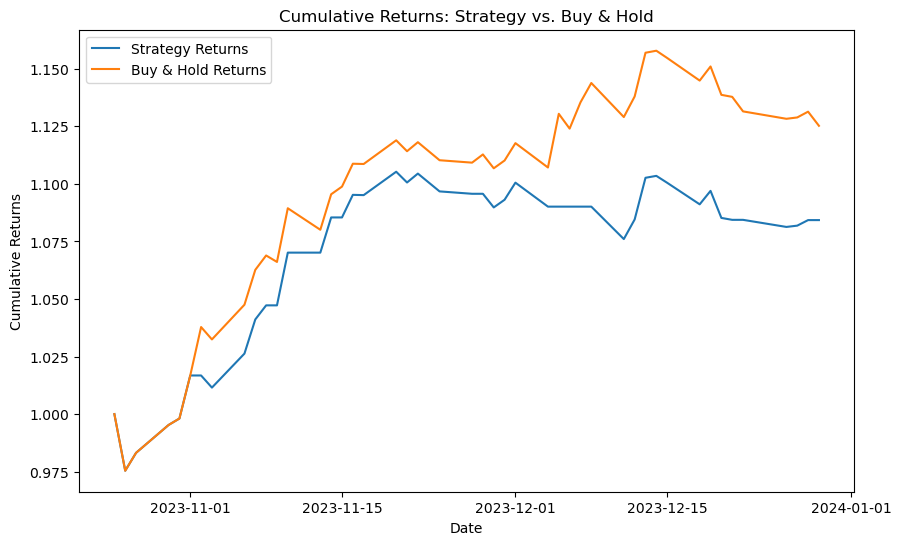

In [27]:
# Generate signals based on model predictions
test_data = historical_data.iloc[-len(y_test):].copy()  # Create a copy of the last portion of historical_data, matching the length of y_test

# Ensure y_pred has the same length as test_data
if len(y_pred) != len(test_data):  # Check if the length of y_pred matches test_data
    y_pred = y_pred[:len(test_data)]  # Trim y_pred if necessary to match the length of test_data

# Add the 'Prediction' column
test_data['Prediction'] = y_pred  # Add a new column 'Prediction' to test_data with values from y_pred

# Calculate strategy returns
# Shift predictions by -1 to align with the next day's return
test_data['Shifted_Prediction'] = test_data['Prediction'].shift()  # Create 'Shifted_Prediction' by shifting 'Prediction' down by one row

# Ensure 'Close' is a single column, if not, select the first column
if isinstance(test_data['Close'], pd.DataFrame):  # Check if 'Close' is a DataFrame
    close_pct_change = test_data['Close'].iloc[:, 0].pct_change()  # If so, select the first column and calculate percentage change
else:
    close_pct_change = test_data['Close'].pct_change()  # If 'Close' is a Series, directly calculate percentage change

# Calculate strategy returns
test_data['Strategy_Return'] = close_pct_change * test_data['Shifted_Prediction']  # Calculate strategy returns by multiplying pct change with shifted predictions

# Calculate cumulative returns
test_data['Cumulative_Strategy_Return'] = (1 + test_data['Strategy_Return'].fillna(0)).cumprod()  # Calculate cumulative returns of the strategy

# Plot cumulative returns
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.plot(test_data['Cumulative_Strategy_Return'], label="Strategy Returns")  # Plot cumulative strategy returns
plt.plot((1 + close_pct_change.fillna(0)).cumprod(), label="Buy & Hold Returns")  # Plot buy & hold cumulative returns
plt.legend()  # Add a legend to differentiate between the two plots
plt.title("Cumulative Returns: Strategy vs. Buy & Hold")  # Set the title of the plot
plt.xlabel("Date")  # Label for the x-axis
plt.ylabel("Cumulative Returns")  # Label for the y-axis
plt.show()  # Display the plot